In [1]:
"""

refer to
    Microphone Array Post-Processor Using Instantaneous Direction of Arrival
Author:
    Wang Wei
"""
import argparse
from time import time

import numpy as np
from scipy.signal import windows
from scipy.signal import convolve2d
from librosa import power_to_db as power_to_db

from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
from DistantSpeech.beamformer.MicArray import MicArray
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import visual
from DistantSpeech.transform.transform import Transform
from DistantSpeech.noise_estimation import McSpp
from DistantSpeech.beamformer.FDGSC import FDGSC, DelayObj

import librosa
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation import McSpp, McSppBase
from DistantSpeech.transform.subband import Subband
from DistantSpeech.adaptivefilter.SubbandLMS import SubbandLMS
from DistantSpeech.beamformer.SubbandGSC import SubbandGSC
from DistantSpeech.beamformer.utils import DelaySamples, DelayFrames
import pyroomacoustics as pra


from pesq import pesq
from pystoi.stoi import stoi

[[ 3.20000000e-02  0.00000000e+00  0.00000000e+00]
 [ 1.95943488e-18  3.20000000e-02  0.00000000e+00]
 [-3.20000000e-02  3.91886976e-18  0.00000000e+00]
 [-5.87830464e-18 -3.20000000e-02  0.00000000e+00]]
The RT60 is 110 ms
(4, 316761)
(257, 1237, 4)


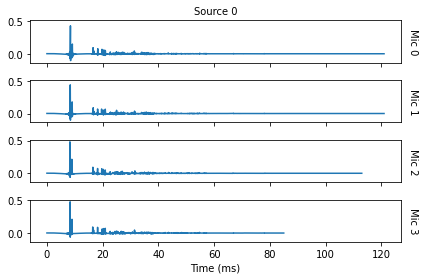

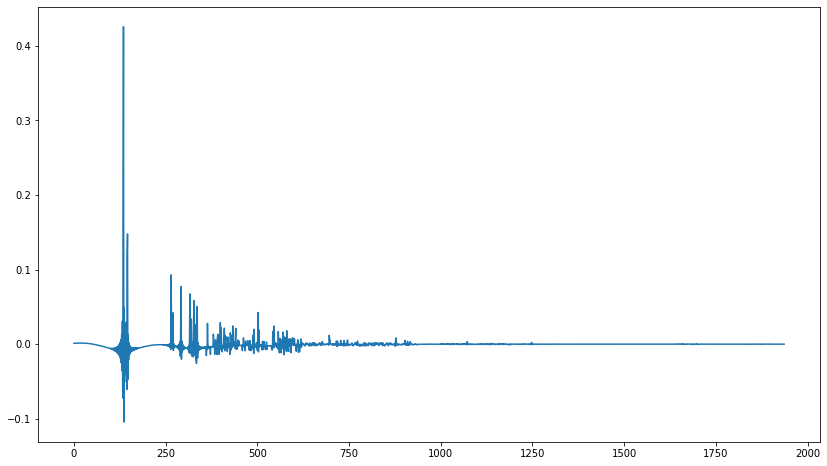

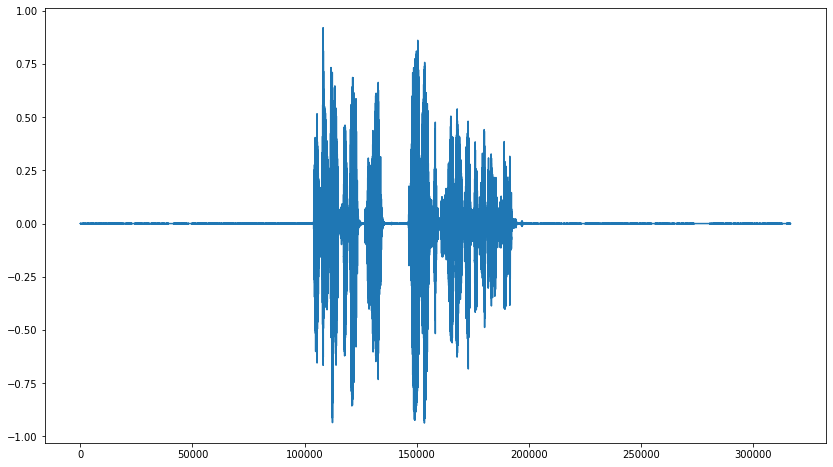

In [2]:
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.032
sound_speed = 343
look_direction = 197
interf_angle = 135

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_3.wav")
# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_5.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

# signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_4.wav")
# # signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
# noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office3.wav")

fs = 16000
M = 4
arrayType="circular"
mic_array = MicArray(arrayType=arrayType, r=mic_diameter, M=M, n_fft=512, energy_absorption=0.75, room_size=[8.0,5.0,3.0])
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
print(mic_array.mic_loc)
array_data, premix = mic_array_sim.generate_audio(signal, source_angle=look_direction, snr=60, source_distance=2.0)
theoretical=True
# audiowrite('coherence/mix.wav', np.transpose(array_data))
# audiowrite('coherence/signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('coherence/interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# target = transform.stft(np.transpose(premix[0, :M, :]))
# transform = Transform(n_fft=512, hop_length=256, channel=M)
# Noise = transform.stft(np.transpose(premix[1, :M, :]))
# print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)
plt.figure(figsize=(14,8))
# plt.plot(mic_array_sim.room.rir[0][0] - mic_array_sim.room.rir[3][0])
plt.plot(mic_array_sim.room.rir[0][0])
plt.show()
# array_data = array_data[:, :160000]
pt(array_data[0, :])

In [3]:
a=np.arange(1,mic_array.M)
np.linalg.norm(a)
print(array_data.shape)
print(mic_array_sim.room.rir[2][0].shape)
pra.constants.get('c')

(4, 316761)
(1809,)


343.0

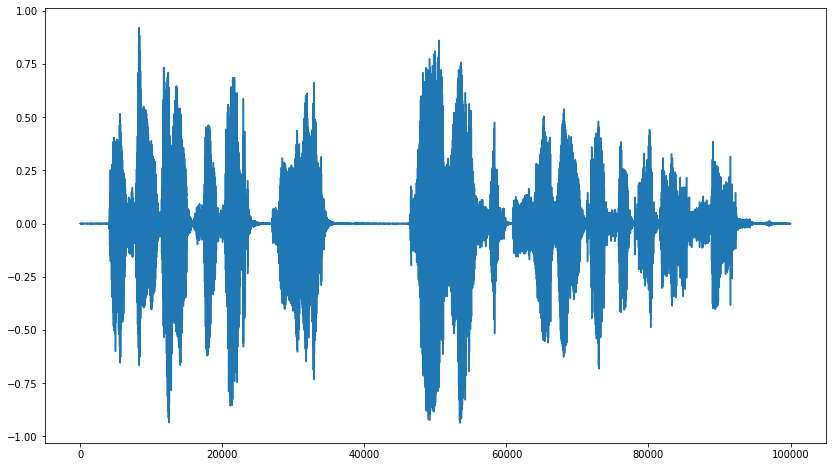

In [4]:

array_data1 = array_data[:, 100000:200000]
pt(array_data1[0])
frameLen = 512

transform = Transform(n_fft=frameLen, hop_length=int(frameLen/2), channel=M)
D = transform.stft(np.transpose(array_data1))
X = D[:128, :, :]
half_bin, n_frames, M = X.shape

6.2260243306019
-6.279202218286905
idoa:(128, 390, 3)


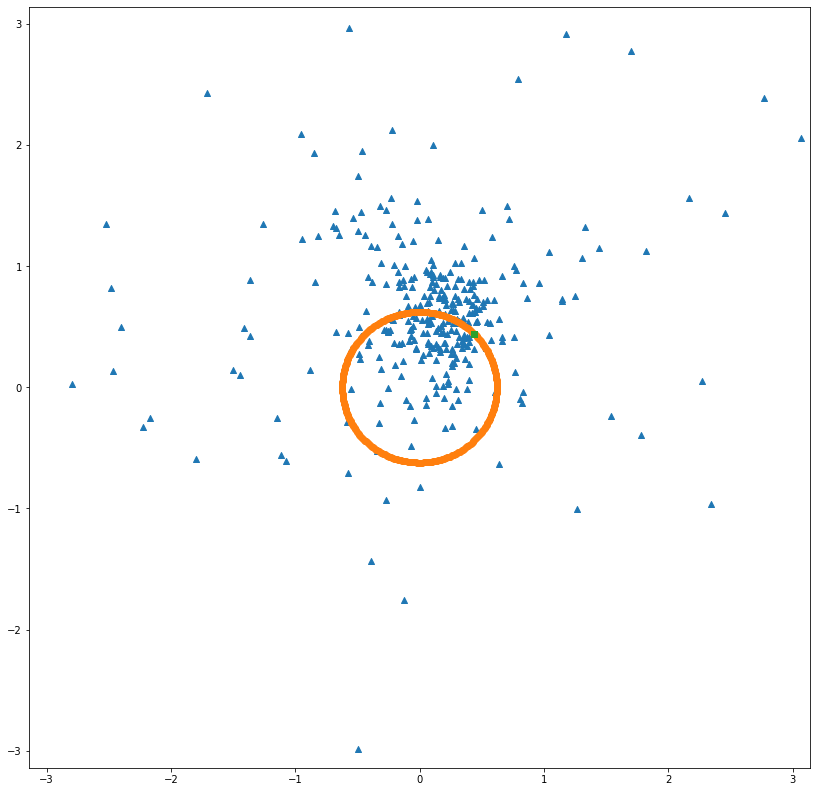

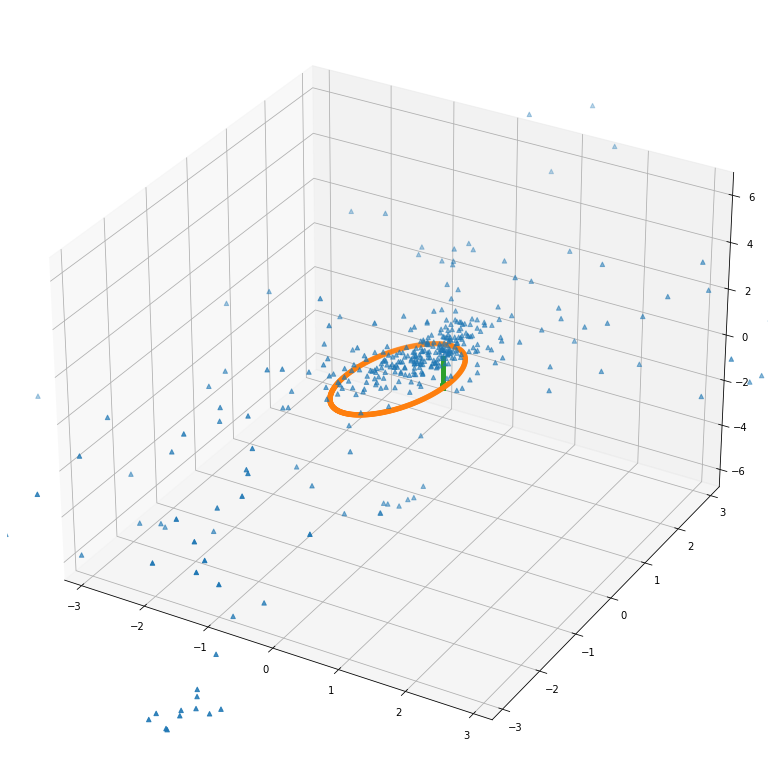

In [5]:
X_diff = X[:, :, 1:] - X[:, :, 0:1]
array_data_diff = array_data1[1:, :] - array_data1[0:1, :]
idoa = np.angle(X[:, :, 1:]) - np.angle(X[:, :, 0:1])
idoa1 = idoa[..., -1]
# pmesh(np.abs(X_diff[..., 2]))
print(np.max(idoa1))
print(np.min(idoa1))
f = 750
k = int(f*transform.n_fft/ mic_array.fs)
print('idoa:{}'.format(idoa.shape))

if arrayType == 'linear':
    theta = np.linspace(0,180, num=180)/180*np.pi
if arrayType == 'circular':
    theta = np.linspace(0,360, num=360)/180*np.pi

n_theta = theta.shape[0]
Psi = np.zeros((half_bin, M-1, n_theta))
Psi_deriv = np.zeros((half_bin, M-1, n_theta))

steer_index = np.arange(1,mic_array.M)
steer_constant = 2*np.pi*mic_array.fs*mic_array.r/mic_array.c/transform.n_fft
for bin in range(half_bin):
    Psi[bin, ...] = steer_constant * bin * steer_index[:, None] @ np.cos(theta[None, :])
    Psi_deriv[bin, ...] = -steer_constant * bin * steer_index[:, None] @ np.sin(theta[None, :])#/180*np.pi

if arrayType == 'circular':
    phi = np.arange(M) * 2.0 * np.pi / M
    for bin in range(half_bin):
        for theta_n in range(theta.shape[0]):
            for m in range(1, M):
                Psi[bin, m-1, theta_n] = steer_constant * bin * (np.cos(theta[theta_n] - phi[m]) - np.cos(theta[theta_n] - phi[0]))
                Psi_deriv[bin, ...] = -steer_constant * bin * (-np.sin(theta[theta_n] - phi[m]) + np.sin(theta[theta_n] - phi[0]))

N = X.shape[1]
r0 = 0.6
x = 2*np.pi * np.random.rand(N) - np.pi
y = 2*np.pi * np.random.rand(N) - np.pi
plt.figure(figsize=(14,14))
plt.scatter(idoa[k,:, 0], idoa[k,:, -1], marker='^')
plt.scatter(Psi[k,0, :].T, Psi[k,-1, :].T, marker='o')
plt.scatter(Psi_deriv[k,0, :].T, Psi_deriv[k,-1, :].T, marker=',')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

plt.show()
# print(max((idoa[:, 0])))
# print(min((idoa[:, 0])))
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(projection='3d')
ax.scatter(idoa[k,:, 0], idoa[k,:, 1], idoa[k, :, -1], marker='^')
ax.scatter(Psi[k,0, :].T, Psi[k,1, :].T, Psi[k, -1, :].T, marker='o')
ax.scatter(Psi_deriv[k,0, :].T, Psi_deriv[k,1, :].T, Psi[k, -1, :].T, marker=',')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
# plt.zlim([-np.pi, np.pi])
plt.show()
# print(Psi[k, ...])


(360,)
(3,)
2.326427212862413
0.0
24


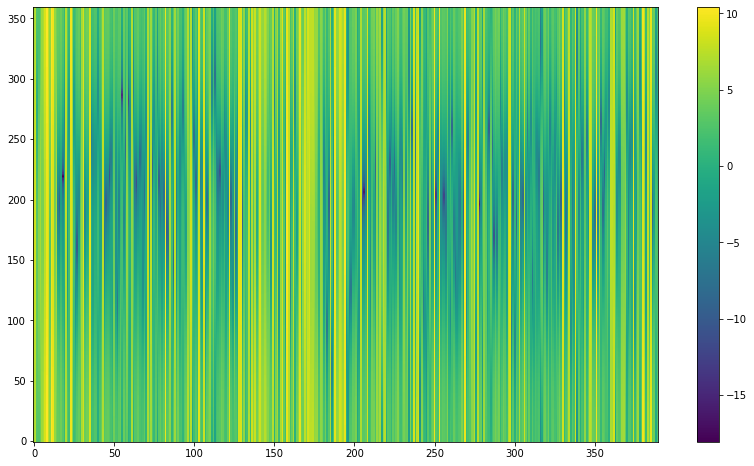

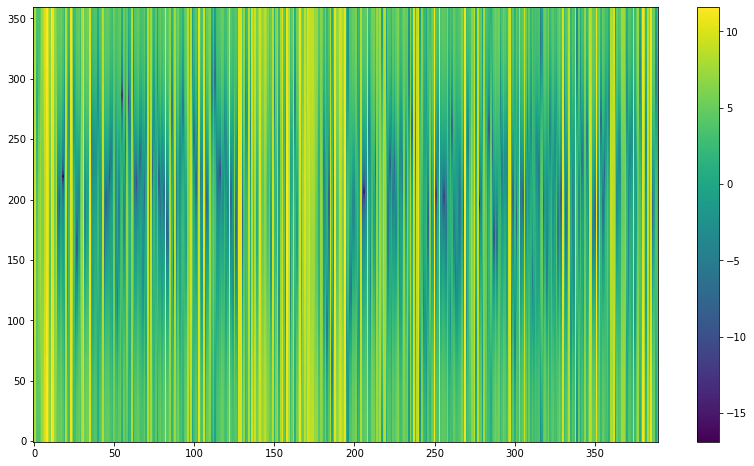

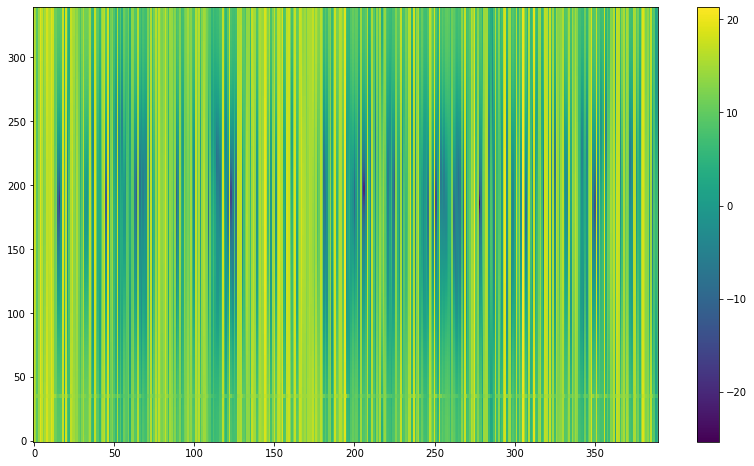

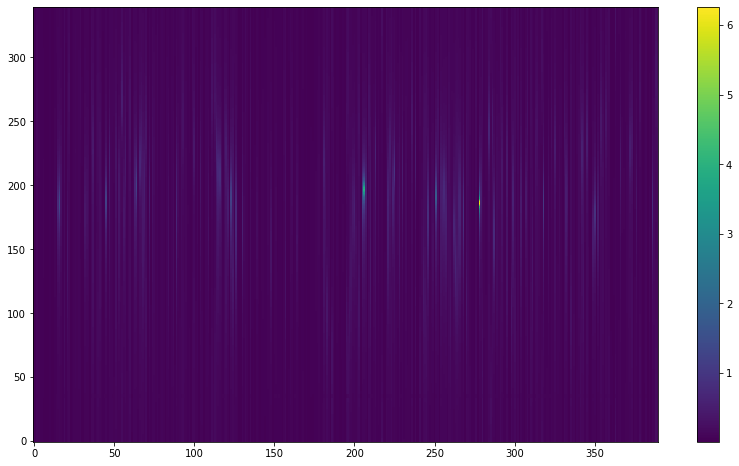

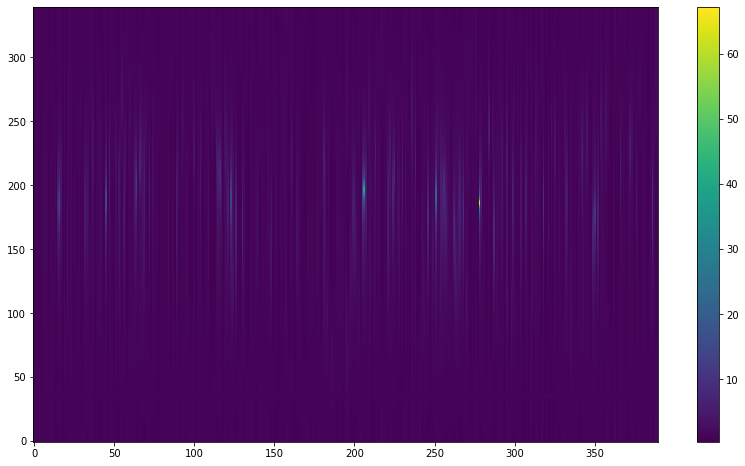

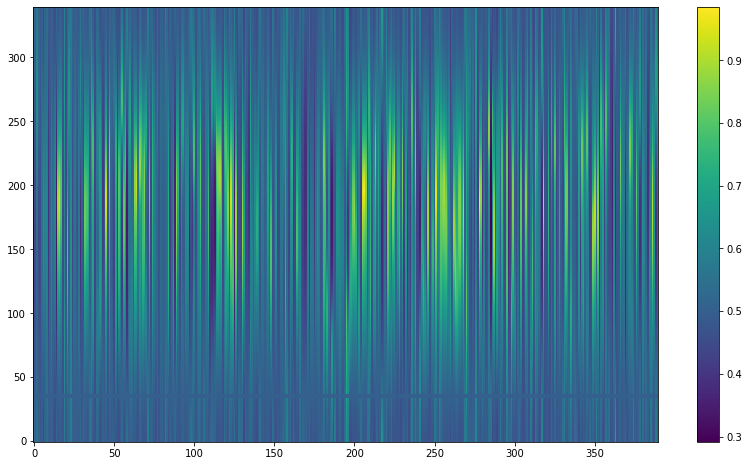

In [6]:

# output_aic,yfbf, bm, p, aligned_output = gsc.process(array_data)

# visual(array_data[0, :], output_aic)

# audiowrite('outputFBF.wav', output_fbf)
# audiowrite('outputSRC.wav', data)
# audiowrite('outputBM.wav', output_bm)
# audiowrite('outputAIC.wav', output_aic)

idoa_dim = (M-1)

# Presence of a sound source
rtf = np.zeros((half_bin, n_frames, idoa_dim, n_theta))
Delta = np.zeros((half_bin, n_frames, idoa_dim))
Delta_norm = np.zeros((half_bin, n_frames, n_theta))
Psi = np.zeros((half_bin, idoa_dim, n_theta))
Psi_deriv = np.zeros((half_bin, idoa_dim, n_theta))
Psi_all = np.zeros((half_bin, n_frames, idoa_dim, n_theta))
gamma = np.zeros((half_bin, n_frames, n_theta))
lambdda = np.zeros((half_bin, n_frames, n_theta))
lambdda = np.zeros((half_bin, n_frames, n_theta)) 
lambdda_avg = np.zeros((half_bin, n_frames, n_theta)) 

Lambda = np.zeros((half_bin, n_frames, n_theta)) 

alpha = 0.02
p = np.zeros((half_bin, n_frames, n_theta))
spp = np.zeros((half_bin, n_frames, n_theta))

steer_index = np.arange(1,mic_array.M)
steer_constant = 2*np.pi*mic_array.fs*mic_array.r/mic_array.c/transform.n_fft

theta_min = 45  # target direction

print(theta.shape)
print(steer_index.shape)

smooth_filter = np.ones((3,3))/9

if arrayType == 'linear':
    for bin in range(half_bin):
        Psi[bin, ...] = -steer_constant * bin * steer_index[:, None] @ np.cos(theta[None, :])
        Psi_deriv[bin, ...] = steer_constant * bin * steer_index[:, None] @ np.sin(theta[None, :])

if arrayType == 'circular':
    phi = np.arange(M) * 2.0 * np.pi / M
    for bin in range(half_bin):
        for theta_n in range(theta.shape[0]):
            for m in range(1, M):
                Psi[bin, m-1, theta_n] = steer_constant * bin * (np.cos(theta[theta_n] - phi[m]) - np.cos(theta[theta_n] - phi[0]))
                Psi_deriv[bin, ...] = -steer_constant * bin * (-np.sin(theta[theta_n] - phi[m]) + np.sin(theta[theta_n] - phi[0]))

print(np.max(Psi_deriv))
print(np.min(Psi_deriv))
Delta[:, :, :] = np.angle(X[:, :, 1:]) - np.angle(X[:, :, 0:1])

for n in range(n_frames):
    # for k in range(half_bin):
    for theta_n in range(n_theta):
        Delta_norm[:, n, theta_n] = np.linalg.norm(Delta[:, n, :] -  Psi[:, :, theta_n], axis=-1)
        gamma[:, n, theta_n] = Delta_norm[:, n, theta_n]/(np.linalg.norm(Psi_deriv[:, :, theta_n], axis=-1) + 1e-6)

    lambdda[:, n, :] = gamma[:, n, :]**2
    if n > 1:
        lambdda[:, n, theta_min] = (1-alpha) * lambdda[:, n-1, theta_min] + alpha * gamma[:, n, theta_min]**2
    lambdda[:, n, :] = convolve2d(lambdda[:, n, :], smooth_filter, mode='same')

    p[:, n, 10:-10] = 1/np.sqrt(2*np.pi*lambdda[:, n, 10:-10] + 1e-6) * np.exp(-(gamma[:, n, 10:-10]**2)/(2*lambdda[:, n, 10:-10] + 1e-6))

    # Lambda[:, n, 10:-10] = p[:, n, 10:-10]/(np.sum(p[:, n, 10:-10], axis=-1, keepdims=True) + 1e-6)
    Lambda[:, n, 10:-10] = p[:, n, 10:-10]/((p[:, n, theta_min:theta_min+1]) + 1e-6)


print(k)
pmesh(power_to_db(Delta_norm[k].T))
pmesh(power_to_db(gamma[k].T))
pmesh(power_to_db(lambdda[k, :, 10:-10].T))
pmesh((p[k, :, 10:-10].T))
pmesh((Lambda[k, :, 10:-10].T))
pmesh((Lambda[k, :, 10:-10].T)/(Lambda[k, :, 10:-10].T + 1))

# for k in range(half_bin):
#     for theta_n in range(n_theta):
#         Psi[k, theta_n, :] = 



In [7]:

x = np.arange(n_frames)
y = np.arange(n_theta)

x_axis, y_axis = np.meshgrid(x, y)

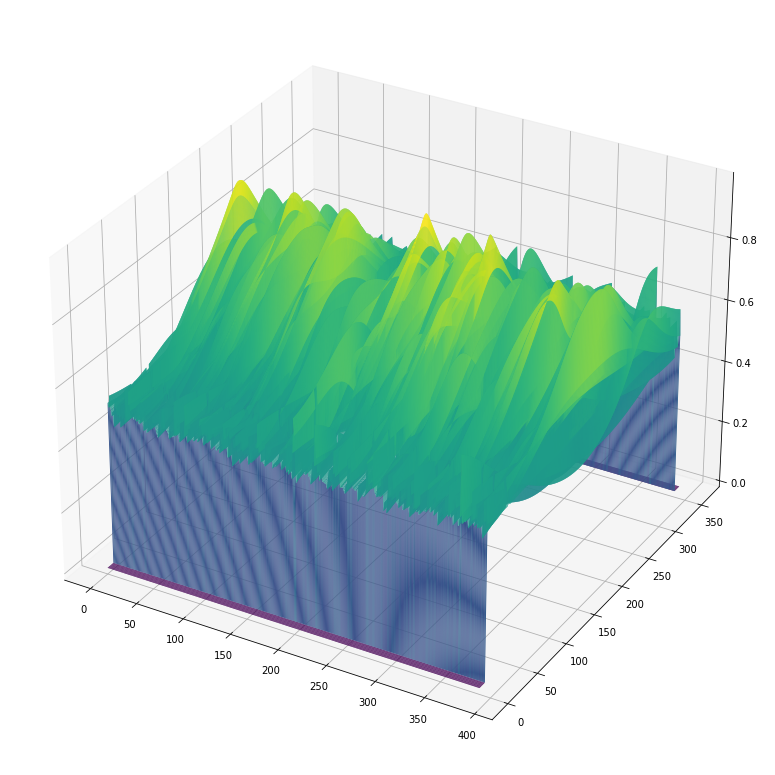

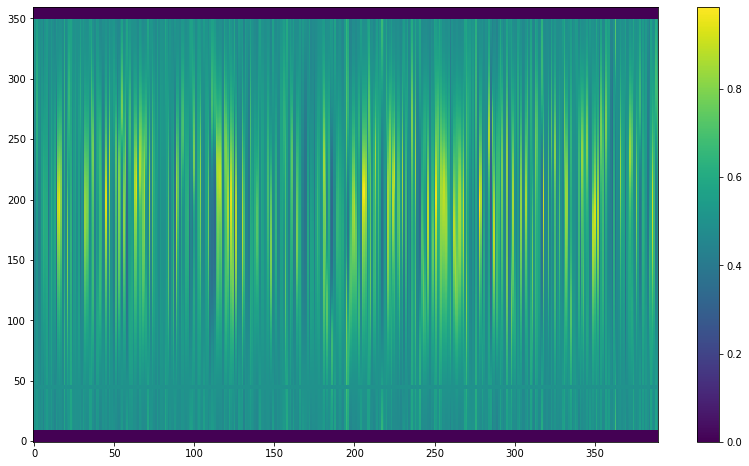

In [8]:
fig = plt.figure(figsize=(14,14))
ax = plt.axes(projection='3d')
Z = Lambda[k, ...].T/(Lambda[k, ...].T+1)
# Z = gamma[k, ...].T
# Z = Delta_norm[k, ...].T

ax.plot_surface(x_axis, y_axis, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
plt.show()
pmesh((Z))
# print((p[:, theta_min]/np.sum(p, keepdims=True) ).shape)
# pmesh(librosa.power_to_db(np.mean(Lambda, axis=1)))
# pmesh(np.mean(Lambda, axis=1)/(1+np.mean(Lambda, axis=1)))